<a href="https://colab.research.google.com/github/StanleyLiangYork/Advance_NN_techniques/blob/main/Recommender_collaborative_filtering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Recommendation System or recommender is a type of AI model that predicts users’ preferences over multiple products. Recommenders are used in a variety of areas, like video and music services, e-commerce, and social media platforms.<p>
The commonly used recommenders are:


1.   Content-Based filtering based on product features
2.   Collaborative filtering based on user similarity
3.   Knowledge based filtering based on personal information

This notebook demonstrates the implementation of collaborative filtering with cosine similarity




In [4]:
# copy the dataset from the Cloud storage
!wget https://storage.googleapis.com/pet-detect-239118/recommender/ratings_small.csv ./ratings_small.csv

--2023-01-18 01:39:35--  https://storage.googleapis.com/pet-detect-239118/recommender/ratings_small.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.79.128, 108.177.127.128, 142.251.31.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.79.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2438266 (2.3M) [text/csv]
Saving to: ‘ratings_small.csv’

ratings_small.csv   100%[===================>]   2.33M  4.94MB/s    in 0.5s    

2023-01-18 01:39:36 (4.94 MB/s) - ‘ratings_small.csv’ saved [2438266/2438266]

--2023-01-18 01:39:36--  http://./ratings_small.csv
Resolving . (.)... failed: No address associated with hostname.
wget: unable to resolve host address ‘.’
FINISHED --2023-01-18 01:39:36--
Total wall clock time: 0.8s
Downloaded: 1 files, 2.3M in 0.5s (4.94 MB/s)


In this type of recommendation system, `we do not need any information` about the users or items. We only need user item interaction data to build a collaborative recommendation system. For example - 
<ol>
    <li><b>Ratings</b> provided by users. For example - ratings of books on goodread, movie ratings on imdb etc</li>
    <li><b>Likes</b> of users on different facebook posts, likes on youtube videos</li>
    <li><b>Use/buying</b> of a product by users. For example - buying different items on e-commerce sites</li>
    <li><b>Reading</b> of articles by readers on various blogs</li>
</ol>    

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
dataset = pd.read_csv('ratings_small.csv')

In [7]:
dataset.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


the dataset contains user ID, movie ID, and the rating scores if the user has seen the movie

In [9]:
# remove the variable timestamp from the dataset
dataset = dataset.drop(['timestamp'], axis=1)

print(dataset.shape)

(100004, 3)


the dataset has 100,004 rows. we also need to find how many unique users and unique movies

In [10]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   userId   100004 non-null  int64  
 1   movieId  100004 non-null  int64  
 2   rating   100004 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 2.3 MB


In [18]:
n_user = dataset['userId'].nunique()
print(f'Number of users: {n_user}')
n_movie = dataset['movieId'].nunique()
print(f'Number of movies: {n_movie}')
# so each user watches more than one movies, but the users do not watch all movies 671X9066 > 100004

Number of users: 671
Number of movies: 9066


In [19]:
# find each user's rating times

dataset['userId'].value_counts()

547    2391
564    1868
624    1735
15     1700
73     1610
       ... 
296      20
289      20
249      20
221      20
1        20
Name: userId, Length: 671, dtype: int64

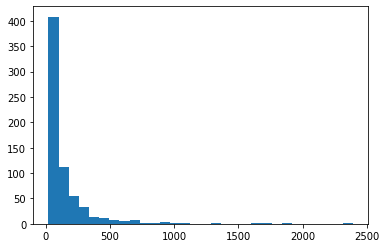

In [21]:
# create a histogram of all the interactions by all the users present in the dataset
interactions = dataset.groupby('userId').count()['movieId']

plt.hist(interactions, bins=30)
plt.show()
# the histogram shows most users just see some movies (less than 100)

Creating user item interactions matrix

In [22]:
# use users as rows and movies as columns, each intersection is the rating score
interactions_matrix = dataset.pivot(index='userId', columns='movieId', values='rating')
print(interactions_matrix.shape)

(671, 9066)


In [23]:
interactions_matrix.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


It seems most movies are not seen by users, so the rating value is NaN <p>
we need to fill the missing value with 0, it means the user has not seen the movie, and we can use the similarity method to predict the rating score

In [24]:
interactions_matrix = interactions_matrix.fillna(0)
interactions_matrix.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Our task is to predict the missing rating scores based on the similarity of users

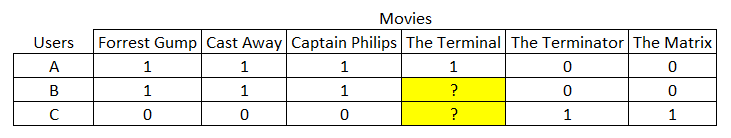

In [25]:
# import cosine_similarity from sklearn
from sklearn.metrics.pairwise import cosine_similarity

# function to measure user similarity based on the interaction matrix
# input - user id of the user to predict his/her missing ratings,
#         the interaction matrix 
# output - a tuple of the similar users and consine similarity score
def similar_users(user_id, interactions_matrix):
    
    # compute similarity of each user to the provided user
    similarity = []
    for user in range(1, interactions_matrix.shape[0]+1):
      # get all the similarity scores
      sim = cosine_similarity([interactions_matrix.loc[user_id]], [interactions_matrix.loc[user]])
      similarity.append((user,sim))
    
    # sort by similarity - higher on top
    similarity.sort(key=lambda x: x[1], reverse=True)
    
    # create list of just the user ids
    most_similar_users = [tup[0] for tup in similarity]
    
    # create list of similarity score
    similarity_score = [tup[1] for tup in similarity]
    
    # remove the user's own id
    most_similar_users.remove(user_id)
    
    # remove the user's own similarity score
    similarity_score.remove(similarity_score[0])
       
    return most_similar_users, similarity_score

In [36]:
# find the top five similar users of user Id 565
top_5_users = similar_users(564, interactions_matrix)[0][:5]
for user in top_5_users:
  print(f'User ID: {user}')

User ID: 306
User ID: 102
User ID: 518
User ID: 232
User ID: 119


In [37]:
top_5_sim_score = similar_users(564, interactions_matrix)[1][:5]
for score in top_5_sim_score:
  print(f'consine similarity: {score.item()}')

consine similarity: 0.4752070970942402
consine similarity: 0.4594583709477716
consine similarity: 0.4580657743022111
consine similarity: 0.4264881863826795
consine similarity: 0.4218847385800824


The collabrative filtering function

In [48]:
def recommendations(user_id, num_of_movies, user_item_interactions, dataset, new_user=False):
  # create an empty list to store the recommended movies
  recommendations = []
  if new_user:
    recommendations = dataset['movieId'].value_counts()[:num_of_movies]
    return recommendations
  else: 
    # find the most similar users to the input user
    most_similar_users = similar_users(user_id, user_item_interactions)[0]
    
    # find out those movies which this user has already seen
    movie_ids = set(list(interactions_matrix.columns[np.where(interactions_matrix.loc[user_id] > 0)]))
    
    # copy those movies which are already seen by the input user - we don't recommend old items
    already_interacted = movie_ids.copy()
    
    # go through each similar user from the list of most_similar_users
    for similar_user in most_similar_users:   
        # find new recommended movie id until it reaches the required recommend numbers
        if len(recommendations) < num_of_movies:    
            
            # get all movie Ids of the similar users
            similar_user_movie_ids = set(list(interactions_matrix.columns[np.where(interactions_matrix.loc[similar_user]> 0)]))
            # add the recommended movie Ids and remove the already seen items
            recommendations.extend(list(similar_user_movie_ids.difference(already_interacted)))
            # Add all already seen items into the already_interacted which we already added in recommendations
            already_interacted = already_interacted.union(similar_user_movie_ids)
            
        else:
            break
    
    return recommendations[:num_of_movies]

In [49]:
# find five recommended movies for user ID 564

recommended_movie_Id = recommendations(564, 5, interactions_matrix, dataset)
for movie_id in recommended_movie_Id:
  print(f'recommended movie ID: {movie_id}')

recommended movie ID: 1537
recommended movie ID: 515
recommended movie ID: 1027
recommended movie ID: 2565
recommended movie ID: 524


In [52]:
# recommend to the new user

recommended_movie_Id = recommendations(564, 5, interactions_matrix, dataset, new_user=True)
for movie_id in recommended_movie_Id:
  print(f'recommended movie ID: {movie_id}')

recommended movie ID: 341
recommended movie ID: 324
recommended movie ID: 311
recommended movie ID: 304
recommended movie ID: 291
